In [1]:
import joblib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

data = joblib.load("../benchmark_v1.1/smaht.mims.jl")

In [2]:
subset = data[data['svlen'] <= 50000].copy()
len(subset)

65120

In [3]:
import sys
import numpy as np

subset['signed_svlen'] = np.where(
    subset['svtype'] == 'DEL',
    -subset['svlen'],
    subset['svlen']
)

SZBINS_I = ['[50,100)', '[100,200)', '[200,300)', '[300,400)',
            '[400,600)', '[600,800)', '[800,1k)', '[1k,2.5k)', '[2.5k,5k)', '>=5k']
SZBINS_D = ['<=5k', '(5k,2.5k]', '(2.5k, 1k]', '(1k,800]', '(800,600]', '(600,400]',
            '(400,300]', '(300,200]', '(200,100]', '(100,50]']

SZBINMAX_I = [50, 100, 200, 300, 400, 600, 800, 1000, 2500, 5000, sys.maxsize]
SZBINMAX_D = [-1 * _ for _ in SZBINMAX_I[::-1]]

# Bin function
def assign_szbin(val):
    if val >= 0:
        return pd.cut([val], bins=SZBINMAX_I, labels=SZBINS_I, right=False)[0]
    else:
        return pd.cut([val], bins=SZBINMAX_D, labels=SZBINS_D, right=True)[0]
    
subset['signed_szbin'] = pd.Categorical(
    subset['signed_svlen'].apply(assign_szbin),
    categories=SZBINS_D + SZBINS_I, 
    ordered=True)

def get_vaf_bin(vaf, bins=[0, 0.05, 0.3, 1], labels=["<5%", "5%-30%", "Germline"]):
    """
    Bin VAFs and apply labels
    """
    return pd.cut(vaf, bins=bins, labels=labels) 
subset['VAF_bin'] = get_vaf_bin(subset['VAF_alt'])

In [4]:
x = subset['TRF'].value_counts()
x[True] / len(subset)

0.6677364864864865

In [5]:
x = subset['NumNeighbors'] != 0
x.sum() / len(subset)

0.7140202702702703

In [6]:
(x & subset['TRF']).sum() / len(subset)

0.5403101965601965

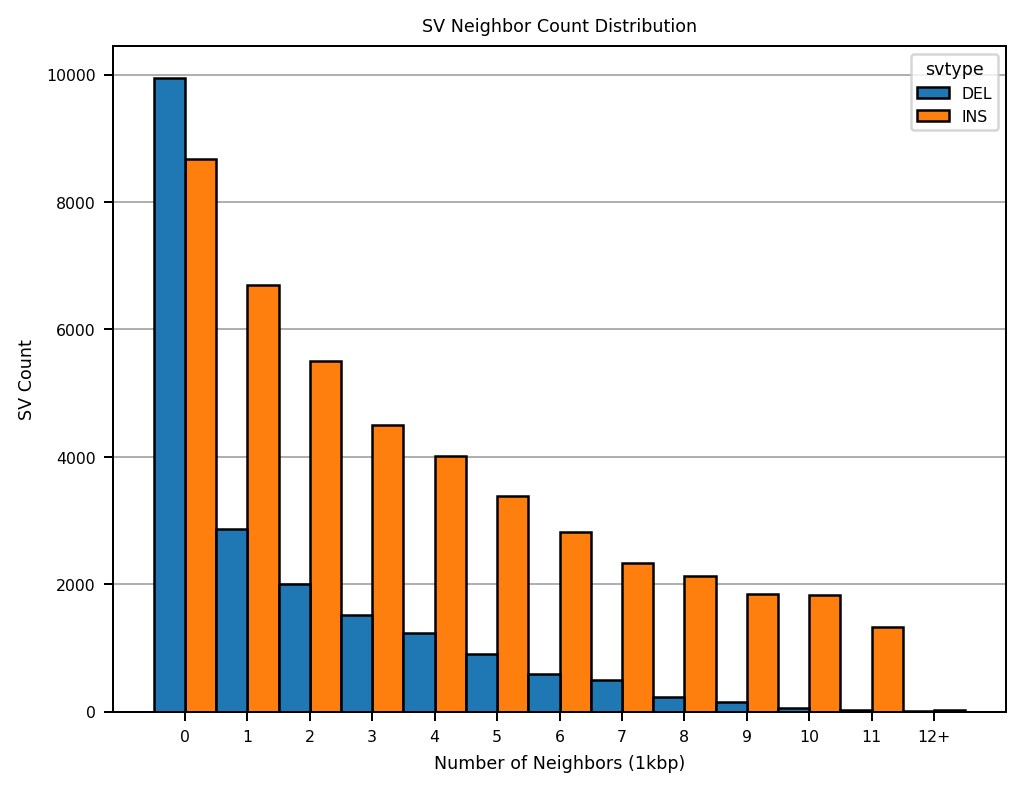

In [23]:
subset = subset.copy()
subset['NumNeighborsCapped'] = subset['NumNeighbors'].clip(upper=12)

plt.figure(dpi=180)
p = sb.histplot(data=subset, 
                x='NumNeighborsCapped', 
                hue='svtype',
                hue_order=['DEL', 'INS'],
                multiple="dodge", 
                binwidth=1,
                discrete=True,
                zorder=2,
                alpha=1)

plt.grid(axis='y', zorder=1)

# Update x-axis ticks to show '12+' for the last bin
xticks = list(range(0, 12)) + ['12+']
p.set_xticks(range(13))
p.set_xticklabels(xticks)
_ = p.set(title="SV Neighbor Count Distribution", xlabel="Number of Neighbors (1kbp)", ylabel="SV Count")

In [5]:

palette = sb.color_palette('deep', n_colors=8) 
palette

def scaled_fontsize(base_size, fig_width, reference_width=6.4, min_size=7):
    """
    Scales the base font size proportionally to figure width,
    but enforces a minimum font size.
    
    base_size: font size for reference_width (in inches)
    fig_width: actual figure width
    """
    scale = fig_width / reference_width
    return max(min_size, base_size * scale)


fig_width = 3.25
font_size = scaled_fontsize(base_size=12, fig_width=fig_width, min_size=7)

plt.rcParams.update({
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size * 0.9,
    "ytick.labelsize": font_size * 0.9,
    "legend.fontsize": font_size * 0.9,
})

# Figure 2 b - SV VAF Dist

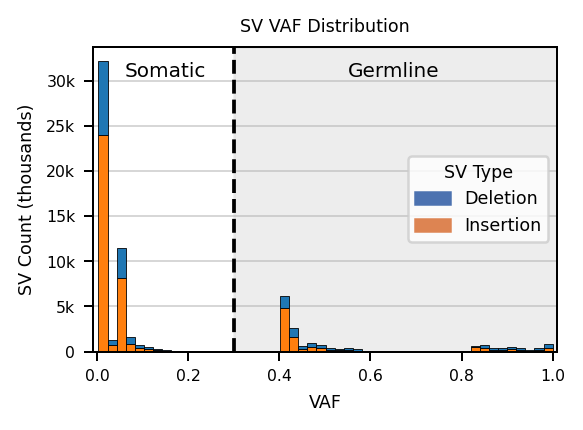

In [7]:

fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       #figsize=(5 * len(files), 5), 
                       figsize=(3.25, 2.4), # For hifi.washu
                       squeeze=False,
                       sharex='row',
                       sharey='row',
                       dpi=180,
                      )

p = sb.histplot(data=subset,
           x='VAF_alt',
           hue="svtype",
           hue_order=['DEL', 'INS'],
           multiple='stack',
           zorder=2,
           binwidth=0.02, 
           alpha=1,
           ax=ax[0][0],
           legend=True,
)

_ = p.set(title="SV VAF Distribution", ylabel="SV Count (thousands)", xlabel="VAF", xlim=(-0.01,1.01))
plt.grid(axis='y', alpha=0.50, zorder=1)

# Shade the area from 0.30 to 1.0
ax[0][0].axvspan(0.30, 1.1, color='lightgray', alpha=0.4, zorder=0)

# Draw the vertical line
ax[0][0].axvline(0.30, color='black', linestyle='--', linewidth=1.5, zorder=3)

# Add text labels for "Somatic" and "Germline"
ylim = ax[0][0].get_ylim()
y_text = ylim[1] * 0.95  # 95% up the Y-axis

ax[0][0].text(0.15, y_text, "Somatic", ha='center', va='top', fontsize=8)
ax[0][0].text(0.65, y_text, "Germline", ha='center', va='top', fontsize=8)

from matplotlib.patches import Patch
palette = sb.color_palette('deep', n_colors=2) 
# Move Legend
legend_handles = [
    Patch(color=palette[0], label='Deletion'),
    Patch(color=palette[1], label='Insertion'),
]

ax[0][0].legend(
    handles=legend_handles,
    loc='center right',
    bbox_to_anchor=(1.0, 0.5),
    bbox_transform=ax[0][0].transAxes,
    frameon=True,
    fontsize=7,
    title="SV Type",
)

# Define formatter function
def thousands_formatter(x, pos):
    return f"{int(x/1000)}k" if x >= 1000 else str(int(x))

# Apply to the axis
ax[0][0].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.tight_layout()
plt.show()


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]

In [88]:
(subset['VAF_alt'] >= 0.3).sum()

16893

In [89]:
(subset['VAF_alt'] >= 0.3).mean()

0.25941339066339064

In [9]:
ax[0][0].get_yticklabels()

[Text(0, -1000.0, '−1000'),
 Text(0, 0.0, '0'),
 Text(0, 1000.0, '1000'),
 Text(0, 2000.0, '2000'),
 Text(0, 3000.0, '3000'),
 Text(0, 4000.0, '4000'),
 Text(0, 5000.0, '5000'),
 Text(0, 6000.0, '6000'),
 Text(0, 7000.0, '7000'),
 Text(0, 8000.0, '8000')]

# Figure 2 A - SV Size Dist

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_5526/287528169.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(plot_df[col]):
/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_5526/287528169.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(plot_df[col]):


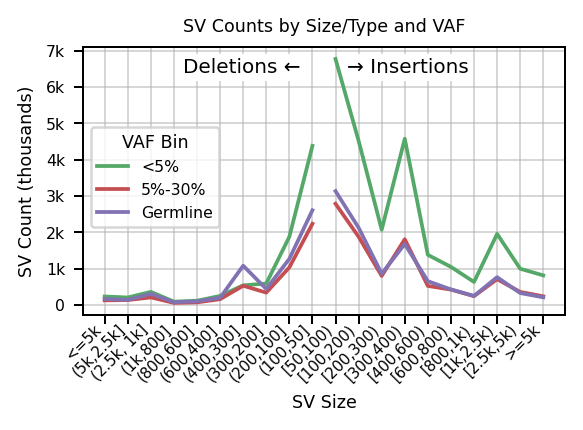

In [6]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       figsize=(3.25, 2.4), # For hifi.washu
                       squeeze=False,
                       sharex='row',
                       sharey='row',
                       dpi=180,
                      )

for i in ['DEL', 'INS']:
    plot_df = subset[subset['svtype'] == i].groupby(['signed_szbin', 'VAF_bin'], observed=True).size().reset_index(name='count')

    # Step 2: Drop unused categories
    for col in ['signed_szbin', 'VAF_bin']:
        if pd.api.types.is_categorical_dtype(plot_df[col]):
            plot_df[col] = plot_df[col].cat.remove_unused_categories()
    # Create the plot
    p = sb.lineplot(
        data=plot_df,
        x='signed_szbin',
        y='count',
        hue='VAF_bin',
        markers=False,
        dashes=True,
        legend=(i=='DEL'),
        ax = ax[0][0],
        zorder=3,
        palette=palette[2:-3],
    )

p.set_title("SV Counts by Size/Type and VAF")
p.set_ylabel("Count")
p.set_xlabel("Size Bin")
p.grid(True, alpha=0.50, zorder=1)
#ax[0][0].set_xticklabels(keep)

# Changing ylabels to thousands (k)
from matplotlib.ticker import FuncFormatter

# Define formatter function
def thousands_formatter(x, pos):
    return f"{int(x/1000)}k" if x >= 1000 else str(int(x))

# Apply to the axis
ax[0][0].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

_ = p.set(ylabel="SV Count (thousands)", xlabel='SV Size')

plt.legend(title="VAF Bin", 
           loc="lower left",
           bbox_to_anchor=(0, 0.3),  # fine-tune as needed
)
plt.xticks(rotation=45, ha='right')
ax[0][0].tick_params(axis='x', which='major', pad=-1, labelsize=6)

ax[0][0].text(8.5, 6800, "Deletions ←", ha='right', va='top', zorder=2, fontsize=8, 
              bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2'))
ax[0][0].text(10.5, 6800, "→ Insertions", ha='left', va='top', zorder=2, fontsize=8,
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2'))



plt.tight_layout()
plt.show()

In [44]:
subset[subset['svtype'] == 'DEL'].groupby(['szbin', 'VAF_bin']).size().unstack()

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1682/1011298287.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset[subset['svtype'] == 'DEL'].groupby(['szbin', 'VAF_bin']).size().unstack()


VAF_bin,<5%,5%-30%,Germline
szbin,,,
SNP,0,0,0
"[1,5)",0,0,0
"[5,10)",0,0,0
"[10,15)",0,0,0
"[15,20)",0,0,0
"[20,30)",0,0,0
"[30,40)",0,0,0
"[40,50)",0,0,0
"[50,100)",4384,2240,2611
